In [1]:
from collections import defaultdict
from tqdm.notebook  import tqdm
from IPython.display import clear_output
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tensor import GTensor
from mlp import MLP
from loss_functions import mean_squared_error
import numpy as np

In [ ]:
def train_model(model, x, y_true, train_steps, learning_rate, plot=True):
    res = defaultdict(list)
    for i in tqdm(range(train_steps)):
        if i % (train_steps // 5) == 0:
            learning_rate *= 0.5
        
        y_pred = model.forward(x)
        loss = mean_squared_error(y_pred=y_pred, y_true=y_true)
        loss.set_is_output()

        if i==0:
            # just in case
            loss.set_track_gradients_full_network(True)
        
        if i % (train_steps // 500) == 0:
            print(f"{i=}, {learning_rate=}, {loss.val=}")

            res["i"].append(i)
            res["loss"].append(loss.val)

            if plot:
                clear_output(wait=True)
                plt.clf()

                res_df = pd.DataFrame(res)
                ax = sns.lineplot(data=res_df, x="i", y="loss")
                ax.set_yscale("log")
                plt.show()

        loss.update_full_network(learning_rate, clear_grad=True, clear_downstream_data=True)
    
    # stop tracking gradients, we don't need them anymore and it causes a massive overhead if doing a forward pass on a lot of data
    loss.set_track_gradients_full_network(False)
    return res_df

/Users/anton/dev/.virtual_envs/default_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/anton/dev/.virtual_envs/default_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


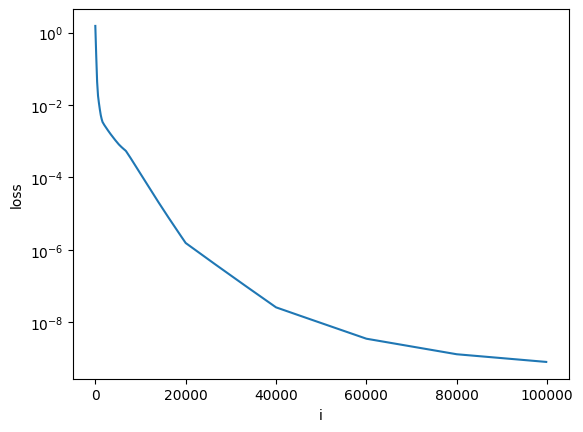

,i,loss
0,0,1.532825e+00
1,200,2.295682e-01
2,400,4.364935e-02
3,600,1.800314e-02
4,800,1.133771e-02
...,...,...
495,99000,8.226981e-10
496,99200,8.186558e-10
497,99400,8.146336e-10
498,99600,8.106314e-10


In [9]:
n_features = 2
n_outputs = 1


x = [
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 2.0],
    [2.0, 0.0],
    [2.0, 2.0],
]

y_true = [0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 4.0]

model = MLP(
    n_inputs=n_features,
    layers=(4, 4, n_outputs),
)


train_model(
    model,
    x=x,
    y_true=y_true,
    train_steps=int(1e5),
    learning_rate=1e-2,
    plot=True,
)

In [10]:
x1_vals = np.arange(0, 5, 0.1)
x2_vals = np.arange(0, 5, 0.1)
a_mesh, b_mesh = np.meshgrid(x1_vals, x2_vals)
combinations = np.vstack([a_mesh.ravel(), b_mesh.ravel()]).T
data_df = pd.DataFrame(combinations, columns=["x1", "x2"])
data_df

,x1,x2
0,0.0,0.0
1,0.1,0.0
2,0.2,0.0
3,0.3,0.0
4,0.4,0.0
...,...,...
2495,4.5,4.9
2496,4.6,4.9
2497,4.7,4.9
2498,4.8,4.9


In [11]:
data_df["y_pred"] = [y_.to_gfloat().val for y_ in model.forward(data_df[["x1", "x2"]].to_numpy().tolist())]
data_df

,x1,x2,y_pred
0,0.0,0.0,0.000037
1,0.1,0.0,0.100029
2,0.2,0.0,0.200021
3,0.3,0.0,0.300013
4,0.4,0.0,0.400005
...,...,...,...
2495,4.5,4.9,7.915161
2496,4.6,4.9,7.983038
2497,4.7,4.9,8.050914
2498,4.8,4.9,8.181314


(0.0, 5.0)

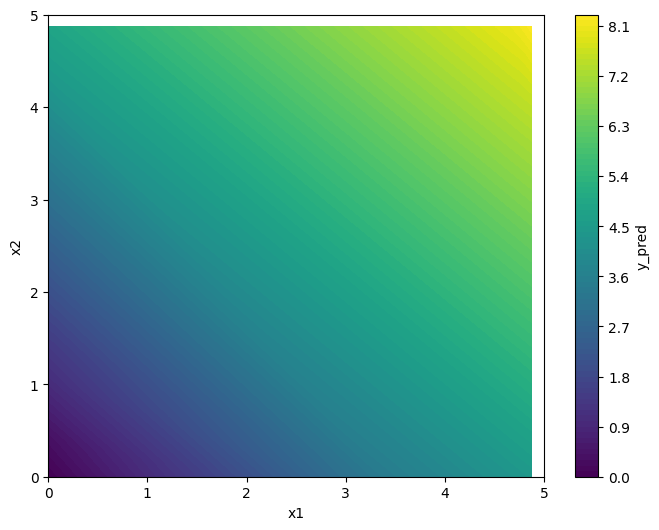

In [12]:
from scipy.interpolate import griddata

grid_x, grid_y = np.mgrid[0:10:200j, 0:10:200j]

grid_hue = griddata((data_df["x1"], data_df["x2"]), data_df["y_pred"], (grid_x, grid_y), method='cubic')

plt.figure(figsize=(8, 6))
contour = plt.contourf(grid_x, grid_y, grid_hue, levels=100, cmap="viridis")
plt.colorbar(contour, label='y_pred')
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(0, 5)
plt.ylim(0, 5)
